Maybe this does not work. We probably have to protect online. This is no major drawback, since e.g. ACI works the same way.

In [8]:
import os
n_cores = 40
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from online_cp import PluginMartingale
from scipy.optimize import brentq
from tqdm.notebook import tqdm

def quantile(p, cdf_func):
# Invert CDF using root-finding (find x such that cdf(x) = p)
    return brentq(lambda x: cdf_func(x) - p, 0, 1)

rnd_gen = np.random.default_rng(2025)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from crepes import WrapRegressor, WrapClassifier

kernel = 'gaussian'

In [9]:
change_point = False

wine_quality = fetch_ucirepo(id=186) 

wine = wine_quality.data.original

if change_point:
    X_test = wine_quality.data.original[wine_quality.data.original.color == 'red'].drop(columns=['quality', 'color'])
    X_train = wine_quality.data.original[wine_quality.data.original.color == 'white'].drop(columns=['quality', 'color'])
    y_test = wine_quality.data.original[wine_quality.data.original.color == 'red']['quality'].astype('float').values
    y_train = wine_quality.data.original[wine_quality.data.original.color == 'white']['quality'].astype('float').values

    X_test = ((X_test - X_test.mean()) / X_test.std()).values
    X_train = ((X_train - X_train.mean()) / X_train.std()).values

else:
    X = wine.drop(columns=['quality', 'color']).values
    Y = wine['quality'].astype('float').values

    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    N = int(X.shape[0]/2)
    X_train = X[:N]
    y_train = Y[:N]
    X_test=X[N:]
    y_test=Y[N:]

cal_size = 0.25
epsilon = 0.1

# Regression

Protected regression:   0%|          | 0/3249 [00:00<?, ?it/s]

Base error rate icp: 0.15481686672822406
Protected error rate icp: 0.09264389042782395

Base width: 2.1199999999999988
Protected width: 2.491917513080948

Base winkler score: 11042.48
Protected winkler score: 10806.84


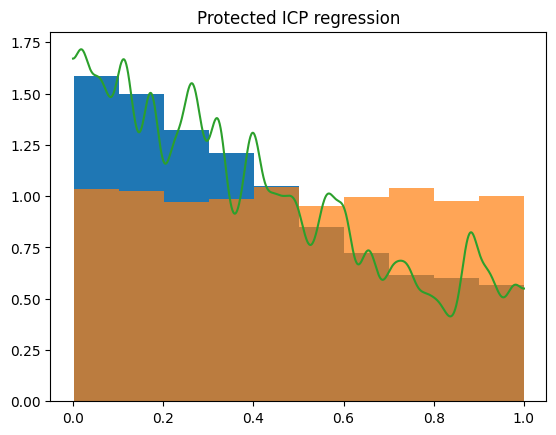

In [10]:
def winkler(intervals, true_values, alpha):
    # Define intervals and true values
    L = intervals[:, 0]  # Lower bounds
    U = intervals[:, 1]  # Upper bounds
    y = true_values      # True values

    # Compute components of Winkler score
    width = U - L  # Interval width
    below = L - y  # Difference when true value is below L
    above = y - U  # Difference when true value is above U

    # Compute Winkler score for each case
    winkler_score = np.where(
        y < L,  # Case 1: y < L
        width + (2 / alpha) * below,
        np.where(
            y > U,  # Case 3: y > U
            width + (2 / alpha) * above,
            width  # Case 2: L <= y <= U
        )
    )
    return winkler_score

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=cal_size, random_state=2024)

rf = RandomForestRegressor(random_state=2025)
icp = WrapRegressor(rf)

icp.fit(X_prop_train, y_prop_train)
icp.calibrate(X_cal, y_cal, seed=2024)

Alpha = icp.cr.alphas

# Base prediction
base_pred = icp.predict_int(X_test, confidence=1-epsilon)

# To fill in the protected predictions
protected_pred = np.empty_like(base_pred)

martingale = PluginMartingale(kernel=kernel, warnings=False) 

p_values = np.empty_like(y_test)

# Out of curiosity
protected_epsilons = np.empty_like(y_test)

for i, (x, y) in tqdm(enumerate(zip(X_test, y_test)), total=y_test.shape[0], desc='Protected regression'):
    alpha = np.abs(icp.predict(np.atleast_2d(x)) - y)
    tau = rnd_gen.uniform(0, 1)
    gt = (Alpha > alpha).sum()
    eq = (Alpha == alpha).sum()
    p = (gt + tau*(eq + 1)) / (Alpha.shape[0] + 1)
    p_values[i] = p
    # Protected significance level
    func = lambda x: martingale.B_n(x) - epsilon
    epsilon_hat = brentq(func, 0, 1)
    protected_pred[i, :] = icp.predict_int(np.atleast_2d(x), confidence=1-epsilon_hat)
    protected_epsilons[i] = epsilon_hat
    martingale.update_martingale_value(p)

protected_p_values = martingale.B_n(p_values)
plt.hist(p_values, density=True)
plt.hist(protected_p_values, density=True, alpha=0.7)
plt.plot(
    np.linspace(0, 1, 1000),
    martingale.b_n(np.linspace(0, 1, 1000)),
    label='Final protection function'
)
plt.title('Protected ICP regression')

print(f"Base error rate icp: {((base_pred[:,0] > y_test).astype(int) + (base_pred[:,1] < y_test).astype(int)).mean()}")
print(f"Protected error rate icp: {((protected_pred[:,0] > y_test).astype(int) + (protected_pred[:,1] < y_test).astype(int)).mean()}")

print()

print(f'Base width: {(base_pred[:,1] - base_pred[:,0]).mean()}')
print(f'Protected width: {(protected_pred[:,1] - protected_pred[:,0]).mean()}')

print()

print(f'Base winkler score: {winkler(base_pred, y_test, epsilon).sum()}')
print(f'Protected winkler score: {winkler(protected_pred, y_test, epsilon).sum()}')

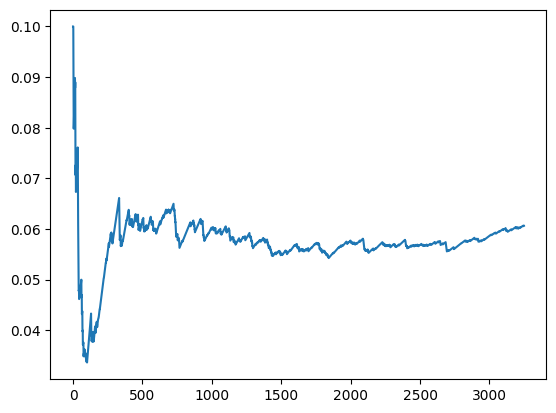

In [11]:
plt.plot(protected_epsilons)

Text(0.5, 1.0, 'Approximate calibration plot regression')

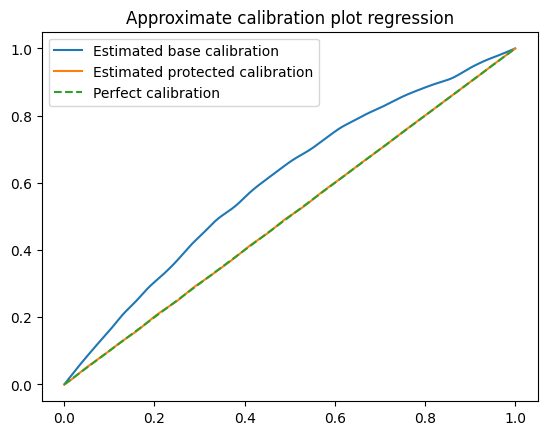

In [12]:
calibration_martingale = PluginMartingale(kernel=kernel, warnings=False) 
for p in protected_p_values:
    calibration_martingale.update_martingale_value(p)

plt.plot(
    np.linspace(0, 1, 1000),
    martingale.B_n(np.linspace(0, 1, 1000)),
    label='Estimated base calibration'
)
plt.plot(
    np.linspace(0, 1, 1000),
    calibration_martingale.B_n(np.linspace(0, 1, 1000)),
    label='Estimated protected calibration'
)
plt.plot(
    np.linspace(0, 1, 1000),
    np.linspace(0, 1, 1000),
    linestyle='--',
    label='Perfect calibration'
)
plt.legend()
plt.title('Approximate calibration plot regression')

# Classification

Protected classification:   0%|          | 0/3249 [00:00<?, ?it/s]

/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:94: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logM)
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:94: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logM)
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:94: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logM)
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:94: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logM)
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:94: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logM)
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/martingale.py:94: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logM)
/home/johan/Docu

Base error rate icp: 0.12526931363496463
Protected error rate icp: 0.0935672514619883

Base OF: 1627.1501727032926
Protected OF: 2250.434462806818

Base OE: 4436
Protected OE: 5174


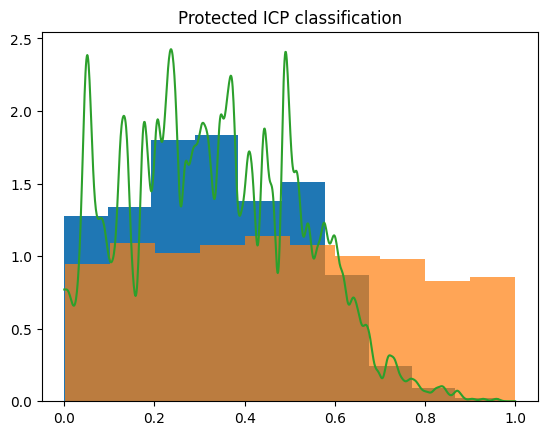

In [13]:
def compute_OE(pred, y_test):
    'Custom for wine dataset...'
    OE = 0
    for i, Gamma in enumerate(pred):
        if Gamma[int(y_test[i]-3)] == 1:
            OE += Gamma.sum()-1
        else:
            OE += Gamma.sum()
    return OE

rf = RandomForestClassifier(random_state=2024)
icp = WrapClassifier(rf)

X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=cal_size, random_state=2024)

icp.fit(X_prop_train, y_prop_train)
icp.calibrate(X_cal, y_cal, seed=2024)

p_test_arr = icp.predict_p(X_test)
idx_truth = (y_test - 3).astype('int')

# Since we can, we predict all p-values in a batch
p_test = p_test_arr[np.arange(p_test_arr.shape[0]), idx_truth]

martingale = PluginMartingale(kernel=kernel, warnings=False)
# In principle, we can batch update the betting function as well.

base_pred = icp.predict_set(X_test, confidence=1-epsilon)

p_test_protected_arr = np.empty_like(p_test_arr)
protected_pred = np.empty_like(base_pred)
# Out of curiosity
protected_epsilons = np.empty_like(y_test)

for i, (x, y) in tqdm(enumerate(zip(X_test, y_test)), total=y_test.shape[0], desc='Protected classification'):
    p = icp.predict_p(np.atleast_2d(x))[0]
    protected_p = martingale.B_n(p)
    p_test_protected_arr[i, :] = protected_p
    # Protected significance level
    func = lambda x: martingale.B_n(x) - epsilon
    epsilon_hat = brentq(func, 0, 1)
    protected_pred[i, :] = icp.predict_set(np.atleast_2d(x), confidence=1-epsilon_hat)
    protected_epsilons[i] = epsilon_hat
    martingale.update_martingale_value(p[int(y-3)])


# Since we can, we predict all p-values in a batch
p_test = p_test_arr[np.arange(p_test_arr.shape[0]), idx_truth]
protected_p_values = p_test_protected_arr[np.arange(p_test_protected_arr.shape[0]), idx_truth]

plt.hist(p_test, density=True)
plt.hist(protected_p_values, density=True, alpha=0.7)
plt.plot(
    np.linspace(0, 1, 1000),
    martingale.b_n(np.linspace(0, 1, 1000)),
    label='Final protection function'
)
plt.title('Protected ICP classification')

print(f"Base error rate icp: {1 - (p_test_arr > epsilon).astype('int')[np.arange(p_test_arr.shape[0]), idx_truth].mean()}")
print(f"Protected error rate icp: {1 - (p_test_protected_arr > epsilon).astype('int')[np.arange(p_test_protected_arr.shape[0]), idx_truth].mean()}")
print()

print(f'Base OF: {p_test_arr.sum() - p_test.sum()}')
print(f'Protected OF: {p_test_protected_arr.sum() - protected_p_values.sum()}')

print()

print(f'Base OE: {compute_OE(base_pred, y_test)}')
print(f'Protected OE: {compute_OE(protected_pred, y_test)}')

Text(0.5, 1.0, 'Approximate calibration plot classification')

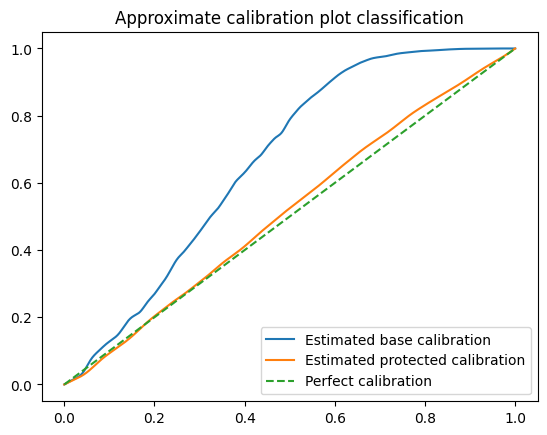

In [14]:
calibration_martingale = PluginMartingale(kernel=kernel, warnings=False) 
for p in protected_p_values:
    calibration_martingale.update_martingale_value(p)

plt.plot(
    np.linspace(0, 1, 1000),
    martingale.B_n(np.linspace(0, 1, 1000)),
    label='Estimated base calibration'
)
plt.plot(
    np.linspace(0, 1, 1000),
    calibration_martingale.B_n(np.linspace(0, 1, 1000)),
    label='Estimated protected calibration'
)
plt.plot(
    np.linspace(0, 1, 1000),
    np.linspace(0, 1, 1000),
    linestyle='--',
    label='Perfect calibration'
)
plt.legend()
plt.title('Approximate calibration plot classification')